In [19]:
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format='svg'

# 数据压缩 (特征抽取)

- Principal component analysis (PCA) 非监督学习数据压缩
- Linear Discriminant Analysis (LDA) 监督学习降维
- kernel principal component analysis 非线性降维

## PCA 非监督学习数据压缩

1. 标准化$d$维数据集
2. 建立协方差矩阵
3. 将协方差矩阵分解为其特征向量和特征值
4. 选择特征值最大的$k$个特征向量
5. 将上面$k$个特征向量建立成一个投影矩阵$W$
6. 将$d$维输入数据$X$通过投影矩阵$W$映射成$k$维特征子空间

### Total and Explained variance

In [20]:
# 首先我们加载 Wine 数据集
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [21]:
# 然后将数据集分成训练集和测试集,并且进行标准化
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)


In [22]:
# 获取Wine协方差矩阵中的特征对
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenvalues \n{}'.format(eigen_vals))



Eigenvalues 
[4.8923083  2.46635032 1.42809973 1.01233462 0.84906459 0.60181514
 0.52251546 0.08414846 0.33051429 0.29595018 0.16831254 0.21432212
 0.2399553 ]


Explained variance 在特征值中的比率指的是
\begin{equation}
\frac{\lambda_j}{\sum_{j=1}^{d}\lambda_j}
\end{equation}

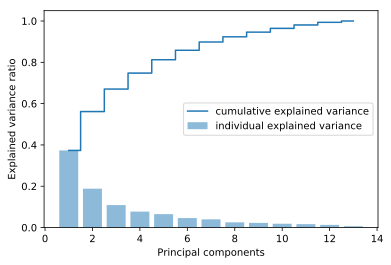

In [23]:
# 下面画出explained variance的累计和的图
import matplotlib.pyplot as plt
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, 14), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')


### 特征转换

In [24]:
# 对特征值降序排列特征对
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse=True)

In [27]:
# 选择前两个特征
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)


Matrix W:
 [[ 0.14669811  0.50417079]
 [-0.24224554  0.24216889]
 [-0.02993442  0.28698484]
 [-0.25519002 -0.06468718]
 [ 0.12079772  0.22995385]
 [ 0.38934455  0.09363991]
 [ 0.42326486  0.01088622]
 [-0.30634956  0.01870216]
 [ 0.30572219  0.03040352]
 [-0.09869191  0.54527081]
 [ 0.30032535 -0.27924322]
 [ 0.36821154 -0.174365  ]
 [ 0.29259713  0.36315461]]


转换样本x到PCA子空间中,得到x'
$$x'=xW$$

In [28]:
X_train_pca = X_train_std @ w

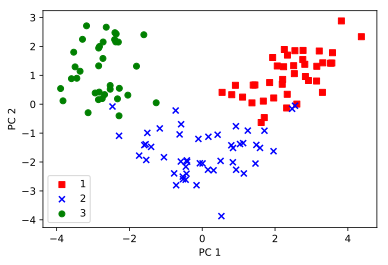

In [30]:
# 画出转换后的Wine数据散点图
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], X_train_pca[y_train == l, 1], c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
